<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/Time_series/Time_series_all_method_2(multy).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mutlity stock tradings

In [53]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import mean_squared_error
#import yfinance as yf
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode

In [3]:
!pip install yahoo_fin

In [38]:
from yahoo_fin.stock_info import get_data

stock_code={'Apple':'AAPL', 'Microsoft':'MSFT','Facebook':'Fb','Amazon':'AMZN',
            'Twitter':'TWTR','SP500':'^GSPC'}

df= get_data(stock_code['SP500'],  start_date = '2016-01-01',
                          end_date='2020-09-05',
                      index_as_date = True, interval="1d")
df_sp500=df['adjclose']
df_sp500

2016-01-04    2012.660034
2016-01-05    2016.709961
2016-01-06    1990.260010
2016-01-07    1943.089966
2016-01-08    1922.030029
                 ...     
2020-08-31    3500.310059
2020-09-01    3526.649902
2020-09-02    3580.840088
2020-09-03    3455.060059
2020-09-04    3426.959961
Name: adjclose, Length: 1178, dtype: float64

In [39]:
df_gld= get_data("GLD",start_date = '2016-01-01',end_date='2020-09-05',
                      index_as_date = True, interval="1d") # Gold price
df_dxy= get_data("UUP",start_date = '2016-01-01',end_date='2020-09-05',
                      index_as_date = True, interval="1d") # Invesco DB US Dollar 
df_ief= get_data("IEF",start_date = '2016-01-01',end_date='2020-09-05',
                      index_as_date = True, interval="1d") # 10 Year Treasury Bond 
df_gush= get_data("GUSH",start_date = '2016-01-01',end_date='2020-09-05',
                      index_as_date = True, interval="1d") # Direxion Daily S&P Oil & Gas Exp. & Prod. Bull 2X Shares

In [40]:
df_assets = pd.DataFrame({
    'GUSH':df_gush['adjclose'],
    'GLD': df_gld['adjclose'],
    'UUP': df_dxy['adjclose'],
    'IEF': df_ief['adjclose'],
})
df_assets

,GUSH,GLD,UUP,IEF
2016-01-04,13072.905273,102.889999,24.894354,97.151749
2016-01-05,12937.333984,103.180000,25.039707,97.124275
2016-01-06,10225.916992,104.669998,24.971874,97.710609
2016-01-07,9538.379883,106.150002,24.719925,97.921371
2016-01-08,9571.303711,105.680000,24.768377,98.168747
...,...,...,...,...
2020-08-31,32.180000,184.830002,24.900000,121.422005
2020-09-01,31.930000,185.050003,24.950001,121.820000
2020-09-02,30.260000,182.619995,25.040001,121.989998
2020-09-03,29.690001,181.139999,25.049999,122.150002


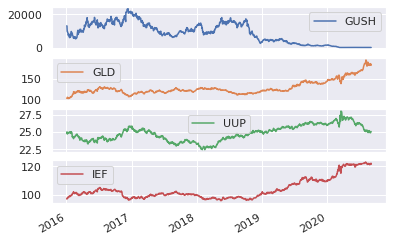

In [41]:
df_assets.plot(subplots=True)
plt.show()

In [42]:
df_assets_1m = df_assets.pct_change(periods=20)
df_assets_1m.columns = ['%s_1m'%col for col in df_assets.columns]
df_assets_3m = df_assets.pct_change(periods=60)
df_assets_3m.columns = ['%s_3m'%col for col in df_assets.columns]
df_assets_6m = df_assets.pct_change(periods=120)
df_assets_6m.columns = ['%s_6m'%col for col in df_assets.columns]
df_lagged = df_assets_1m.join(df_assets_3m)\
    .join(df_assets_6m)\
    .dropna()
df_lagged

,GUSH_1m,GLD_1m,UUP_1m,IEF_1m,GUSH_3m,GLD_3m,UUP_3m,IEF_3m,GUSH_6m,GLD_6m,UUP_6m,IEF_6m
2016-06-24,-0.089693,0.080803,0.005274,0.023376,0.362538,0.071064,0.009780,0.021509,0.069037,0.224609,-0.035422,0.065996
2016-06-27,-0.221128,0.095658,0.008068,0.034201,0.208813,0.083383,0.018752,0.030639,-0.088323,0.227757,-0.032895,0.075516
2016-06-28,-0.131674,0.079786,0.001208,0.032793,0.429689,0.078950,0.014688,0.029242,0.315152,0.197287,-0.034924,0.068873
2016-06-29,-0.102122,0.085389,0.003644,0.028942,0.561814,0.069522,0.010599,0.020984,0.503147,0.185492,-0.028224,0.062237
2016-06-30,-0.134927,0.093369,0.004448,0.028033,0.381693,0.081495,0.014706,0.025472,0.456900,0.196726,-0.028169,0.061910
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,-0.027501,-0.004363,-0.015032,-0.009214,-0.395541,0.169736,-0.049981,0.016272,0.109911,0.200741,-0.048165,0.034337
2020-09-01,-0.070992,-0.023946,-0.009528,-0.009359,-0.523891,0.158590,-0.045524,0.018498,0.478582,0.252115,-0.056354,0.037200
2020-09-02,-0.157338,-0.045623,-0.001595,-0.004660,-0.470394,0.132457,-0.039140,0.016274,-0.022384,0.274567,-0.087464,0.045463
2020-09-03,-0.143393,-0.065759,-0.001196,-0.004491,-0.390834,0.107416,-0.033938,0.010052,0.217084,0.278876,-0.056852,0.019892


# Model

## Linger Regression

Tóm tắt:
Viết chương trình để xác định giá trị cổ phiếu SP500 dựa trên giá trị cổ phiếu gold, oil.... (pair trading). Lấy 20 giá trị trước hiện tại của GS train với 20 giá trị trước hiện tại của jpm, sau đó lấy model này predict giá trị hiện tại jpm dựa trên giá trị hiện tại của GS. model liner sẽ train và predict từng cặp 20 giá trị này cho tới hết data set.

Training set:

x.shape (20, 1)

y.ravel().shape (20,)

X: 20 sample, 1 feature; Y: 20 samples

Khi lấy model này predict bao nhiêu giá trị x thì sẽ có tương ứng bấy nhiêu giá trị y. Ở đây train x và y theo 1-1, tức là chúng ta có linear model của 20 giá trị x theo 20 giá trị y, dùng model này để predict giá trị current

Đây là model sống, nghĩa là model parameter sẽ thay đổi theo mỗi 20 giá trị tiếp theo, sau đó predict giá trị current. Cách train này khá hay , giống với ARIMA

ML thông thường: X (2658,60); Y (2658,) tức là X có 60 features tượng trưng 60 timesteps, 2658 phần tử. Y cũng có 2658 giá trị tương ứng với 2658 giá trị X. Sau khi train hết rồi thì được model, model này sẽ dùng để predict X test (300,60). Đây là model chết do chỉ dùng parameter cũ để predict y theo X, mặc dù X ở đây là giá trị gần với y (30 or 60 ngày gần nhất)

In [57]:
from sklearn.linear_model import LinearRegression

class LinearRegressionModel(object):
    def __init__(self):
        self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])

    def get_model(self):
        return LinearRegression(fit_intercept=False)

    def learn(self, df, ys, start_date, end_date, lookback_period=20):
        model = self.get_model()
        #print('++def learn')
        #print('start_date',start_date)
        #print('end_date',start_date)
        #print('lookback_period',lookback_period)
        for date in df[start_date:end_date].index:
            # Fit the model
            x = self.get_prices_since(df, date, lookback_period)
            y = self.get_prices_since(ys, date, lookback_period)
            #print('----date',date)
            #print('x',x)
            #print('y',y)
            #print('y.ravel()',y.ravel())
            #print('x.shape',x.shape)
            #print('y.ravel().shape',y.ravel().shape)
            model.fit(x, y.ravel())
            #print('model.predict(x)',model.predict(x))
            # Predict the current period
            #print('Predict the current period')
            #print('date ',date)
            x_current = df.loc[date].values
            [y_pred] = model.predict([x_current])
            #print('x_current',x_current)
            #print('[y_pred]',[y_pred])

            # Store predictions
            new_index = pd.to_datetime(date, format='%Y-%m-%d')
            y_actual = ys.loc[date]
            #print('y_actual',y_actual)
            self.df_result.loc[new_index] = [y_actual, y_pred]

    def get_prices_since(self, df, date_since, lookback):

        index = df.index.get_loc(date_since) # current date
        #print('++def get_prices_since')
        #print('date_since',date_since)
        #print('index',index)
        #print('index-lookback:index',index-lookback,index) 
        return df.iloc[index-lookback:index] #current date - 20 : current date


In [44]:
df_sp500

2016-01-04    2012.660034
2016-01-05    2016.709961
2016-01-06    1990.260010
2016-01-07    1943.089966
2016-01-08    1922.030029
                 ...     
2020-08-31    3500.310059
2020-09-01    3526.649902
2020-09-02    3580.840088
2020-09-03    3455.060059
2020-09-04    3426.959961
Name: adjclose, Length: 1178, dtype: float64

In [45]:
df_assets

,GUSH,GLD,UUP,IEF
2016-01-04,13072.905273,102.889999,24.894354,97.151749
2016-01-05,12937.333984,103.180000,25.039707,97.124275
2016-01-06,10225.916992,104.669998,24.971874,97.710609
2016-01-07,9538.379883,106.150002,24.719925,97.921371
2016-01-08,9571.303711,105.680000,24.768377,98.168747
...,...,...,...,...
2020-08-31,32.180000,184.830002,24.900000,121.422005
2020-09-01,31.930000,185.050003,24.950001,121.820000
2020-09-02,30.260000,182.619995,25.040001,121.989998
2020-09-03,29.690001,181.139999,25.049999,122.150002


In [58]:
linear_reg_model = LinearRegressionModel()
linear_reg_model.learn(df_assets, df_sp500, start_date='2017', 
                       end_date='2020', lookback_period=10)

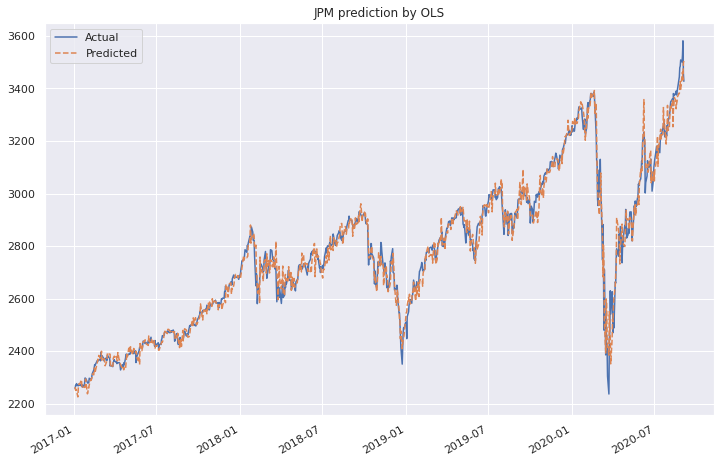

In [48]:
linear_reg_model.df_result.plot(
    title='JPM prediction by OLS', 
    style=['-', '--'], figsize=(12,8));

In [47]:
linear_reg_model.df_result

,Actual,Predicted
2017-01-03,2257.830078,2264.084740
2017-01-04,2270.750000,2251.630106
2017-01-05,2269.000000,2254.861399
2017-01-06,2276.979980,2250.920645
2017-01-09,2268.899902,2226.464370
...,...,...
2020-08-31,3500.310059,3450.913382
2020-09-01,3526.649902,3461.757692
2020-09-02,3580.840088,3431.633567
2020-09-03,3455.060059,3497.122739


In [51]:
y_test=linear_reg_model.df_result.Actual[-186:]
y_test_pred=linear_reg_model.df_result.Predicted[-186:]

In [54]:
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))

test rmse: 63.54540410583514


In [55]:
def profit(true,predict):
  buy=0
  win=0
  lose=0
  revenue=[]
  for i in range(len(predict)-1):
    if predict.values[i+1] > true.values[i]:
      buy+=1
      result=true.values[i+1]-true.values[i]
      revenue.append(result)
      if result >0:
        win+=1
      else:
        lose+=1
  print('total buy',buy)      
  print('ratio buy/all test set:',buy/len(predict))      
  print('win num',win)
  print('lose num',lose)
  print('revenue',sum(revenue))

In [56]:
profit(y_test,y_test_pred)

total buy 98
ratio buy/all test set: 0.5268817204301075
win num 72
lose num 26
revenue 2027.949462890625


## Ridge regression

In [59]:
from sklearn.linear_model import LinearRegression

class LinearRegressionModel(object):
    def __init__(self):
        self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])

    def get_model(self):
        return LinearRegression(fit_intercept=False)

    def learn(self, df, ys, start_date, end_date, lookback_period=20):
        model = self.get_model()

        for date in df[start_date:end_date].index:
            # Fit the model
            x = self.get_prices_since(df, date, lookback_period)
            y = self.get_prices_since(ys, date, lookback_period)
            model.fit(x, y.ravel())
            # Predict the current period
            x_current = df.loc[date].values
            [y_pred] = model.predict([x_current])
            # Store predictions
            new_index = pd.to_datetime(date, format='%Y-%m-%d')
            y_actual = ys.loc[date]
            self.df_result.loc[new_index] = [y_actual, y_pred]

    def get_prices_since(self, df, date_since, lookback):

        index = df.index.get_loc(date_since) # current date
        return df.iloc[index-lookback:index] #current date - 20 : current date


In [60]:
from sklearn.linear_model import Ridge
# class Ridge kế thừa tất cả thuộc tính của class Linear, chỉ thay đổi get_model method
class RidgeRegressionModel(LinearRegressionModel):        
    def get_model(self):
        return Ridge(alpha=.5)

In [61]:
ridge_reg_model = RidgeRegressionModel()
ridge_reg_model.learn(df_assets, df_sp500, start_date='2017', 
                       end_date='2020', lookback_period=10)

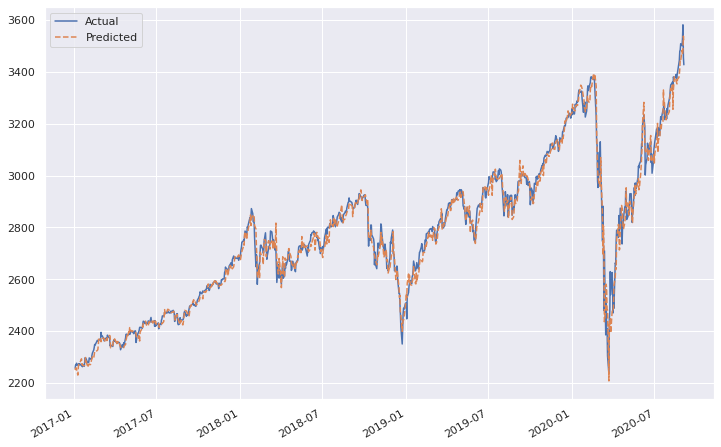

In [63]:
ridge_reg_model.df_result.plot(
    #title='JPM prediction by OLS', 
    style=['-', '--'], figsize=(12,8));